## Import Necessary Modules

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

%matplotlib inline

## Data Preparation & Preprocessing

In [2]:
def crop_brain_contour(image, plot=False):
    
    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

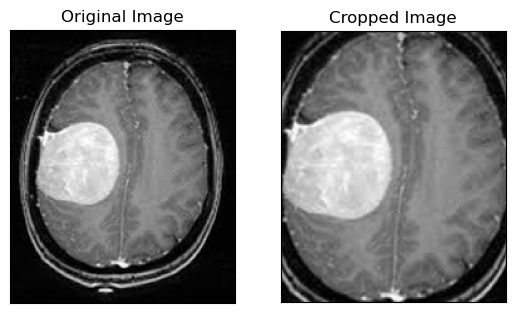

In [3]:
ex_img = cv2.imread('yes/Y1.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

In [4]:
def load_data(dir_list, image_size):
    """
    Read images, resize and normalize them. 
    Arguments:
        dir_list: list of strings representing file directories.
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            # load the image
            image = cv2.imread(directory + '\\' + filename)
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [5]:
augmented_path = 'augmented data/'

# augmented data (yes and no) contains both the original and the new generated examples
augmented_yes = augmented_path + 'yes' 
augmented_no = augmented_path + 'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 2064
X shape is: (2064, 240, 240, 3)
y shape is: (2064, 1)


### Plot sample images:

In [6]:
def plot_sample_images(X, y, n=50):
    """
    Plots n sample images for both values of y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """
    
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

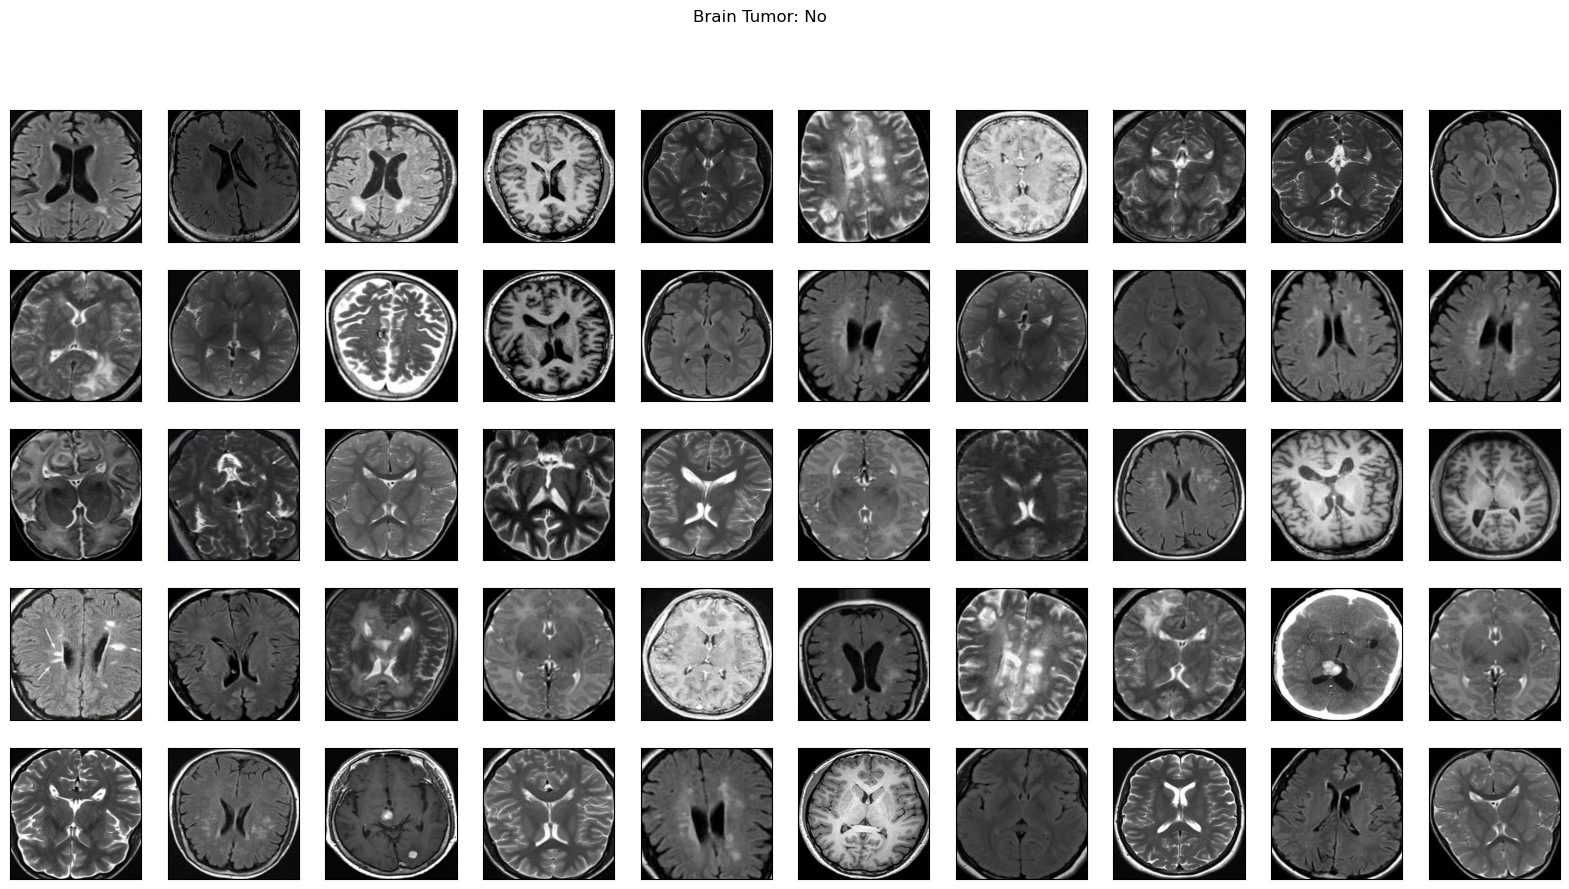

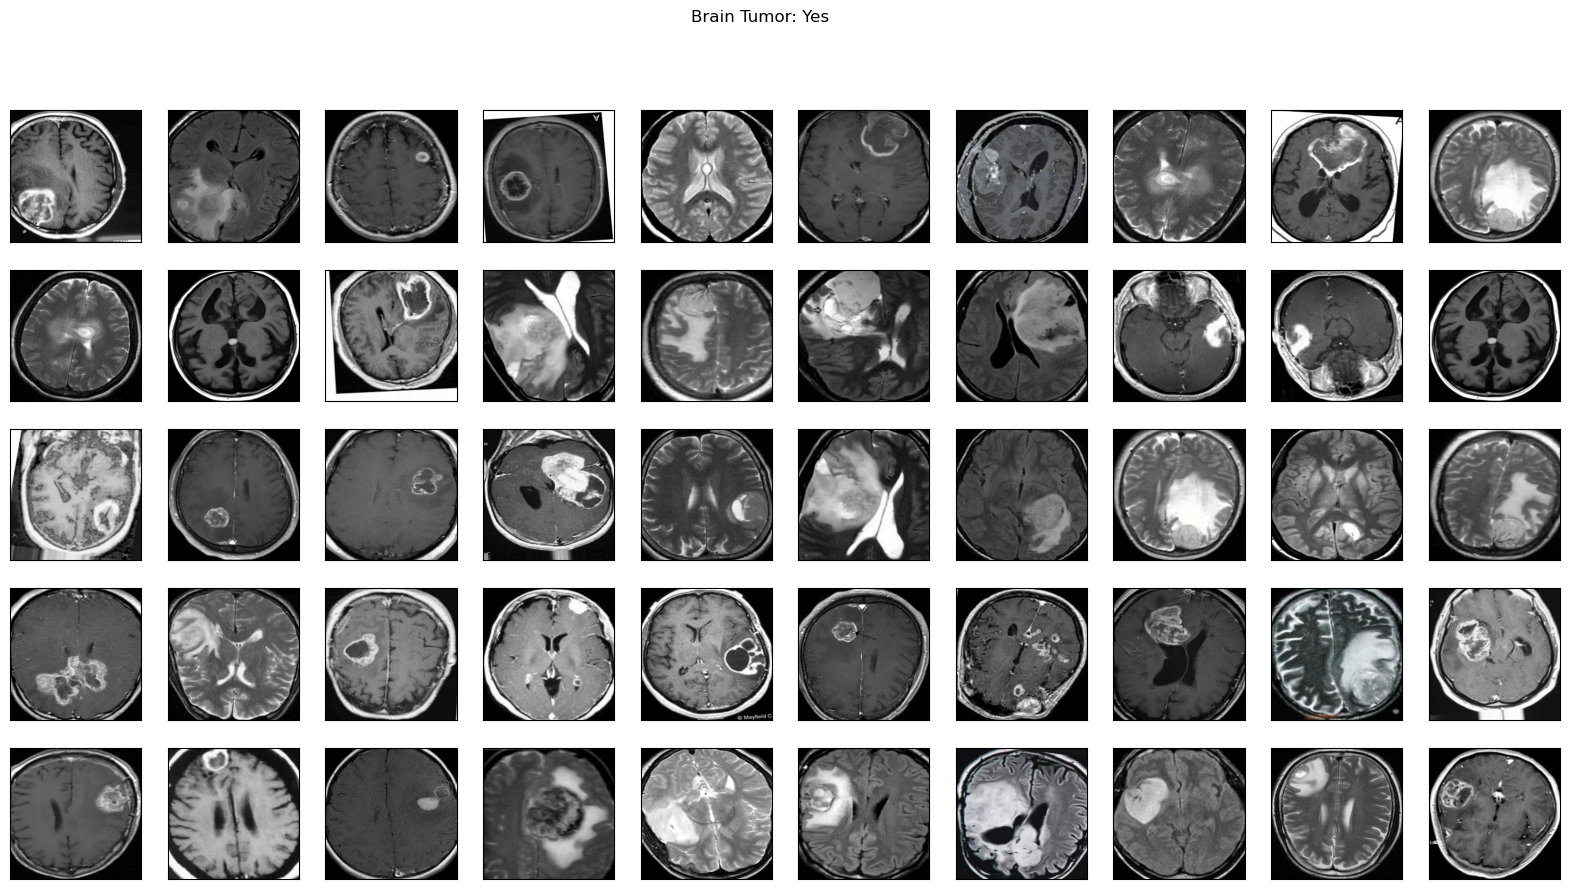

In [7]:
plot_sample_images(X, y)

### Split the data:

In [8]:
def split_data(X, y, test_size=0.2):
       
    """
    Splits data into training, development and test sets.
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    Returns:
        X_train: A numpy array with shape = (#_train_examples, image_width, image_height, #_channels)
        y_train: A numpy array with shape = (#_train_examples, 1)
        X_val: A numpy array with shape = (#_val_examples, image_width, image_height, #_channels)
        y_val: A numpy array with shape = (#_val_examples, 1)
        X_test: A numpy array with shape = (#_test_examples, image_width, image_height, #_channels)
        y_test: A numpy array with shape = (#_test_examples, 1)
    """
    
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [9]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [10]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 1444
number of development examples = 310
number of test examples = 310
X_train shape: (1444, 240, 240, 3)
Y_train shape: (1444, 1)
X_val (dev) shape: (310, 240, 240, 3)
Y_val (dev) shape: (310, 1)
X_test shape: (310, 240, 240, 3)
Y_test shape: (310, 1)


In [11]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [12]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

# Build the model

In [27]:
from tensorflow.keras.layers import Dropout

def build_model(input_shape):
    """
    Arguments:
        input_shape: A tuple representing the shape of the input of the model. shape=(image_width, image_height, #_channels)
    Returns:
        model: A Model object.
    """
    # Define the input placeholder as a tensor with shape input_shape.
    X_input = Input(input_shape)  # shape=(?, 240, 240, 3)

    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input)  # shape=(?, 244, 244, 3)

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides=(1, 1), name='conv0')(X)
    X = BatchNormalization(axis=3, name='bn0')(X)
    X = Activation('relu')(X)  # shape=(?, 238, 238, 32)

    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X)  # shape=(?, 59, 59, 32)

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(64, (5, 5), strides=(1, 1), name='conv1')(X)
    X = BatchNormalization(axis=3, name='bn1')(X)
    X = Activation('relu')(X)  # shape=(?, 55, 55, 64)

    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X)  # shape=(?, 13, 13, 64)

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(128, (3, 3), strides=(1, 1), name='conv2')(X)
    X = BatchNormalization(axis=3, name='bn2')(X)
    X = Activation('relu')(X)  # shape=(?, 11, 11, 128)

    # MAXPOOL
    X = MaxPooling2D((2, 2), name='max_pool2')(X)  # shape=(?, 5, 5, 128)

    # FLATTEN X
    X = Flatten()(X)  # shape=(?, 3200)
    # DROPOUT
    X = Dropout(0.5)(X)
    # FULLYCONNECTED
    X = Dense(512, activation='relu', name='fc1')(X)  # shape=(?, 512)
    # DROPOUT
    X = Dropout(0.5)(X)
    # FULLYCONNECTED
    X = Dense(256, activation='relu', name='fc2')(X)  # shape=(?, 256)
    # DROPOUT
    X = Dropout(0.5)(X)
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc3')(X)  # shape=(?, 1)

    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs=X_input, outputs=X, name='BrainDetectionModel')

    return model


In [28]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [29]:
model = build_model(IMG_SHAPE)

In [30]:
model.summary()

Model: "BrainDetectionModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 240, 240, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ zero_padding2d_2 (ZeroPadding2D)     │ (None, 244, 244, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv0 (Conv2D)                       │ (None, 238, 238, 32)        │           4,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn0 (BatchNormalization)             │ (None, 238, 238, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 238, 238, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pool0 (MaxPooling2D)             │ (None, 59, 59, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 55, 55, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn1 (BatchNormalization)             │ (None, 55, 55, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 55, 55, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pool1 (MaxPooling2D)             │ (None, 13, 13, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2 (Conv2D)                       │ (None, 11, 11, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn2 (BatchNormalization)             │ (None, 11, 11, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 11, 11, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pool2 (MaxPooling2D)             │ (None, 5, 5, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 3200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 3200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 512)                 │       1,638,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc2 (Dense)                          │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc3 (Dense)                          │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 1,901,249 (7.25 MB)

 Trainable params: 1,900,801 (7.25 MB)

 Non-trainable params: 448 (1.75 KB)

Compile the model:

In [31]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [33]:
from tensorflow.keras.callbacks import ModelCheckpoint

# ModelCheckpoint callback tanımı
checkpoint_filepath = './models/best_cnn_model{epoch:02d}-{val_accuracy:.2f}.keras'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_best_only=True
)



## Train the model

In [35]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val),     callbacks=[model_checkpoint_callback])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5388 - loss: 1.4144
Epoch 1: val_accuracy improved from -inf to 0.53548, saving model to ./models/best_cnn_model01-0.54.keras
46/46 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.5397 - loss: 1.4091 - val_accuracy: 0.5355 - val_loss: 0.6835
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6943 - loss: 0.7014
Epoch 2: val_accuracy did not improve from 0.53548
46/46 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.6945 - loss: 0.7003 - val_accuracy: 0.5355 - val_loss: 0.6788
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7441 - loss: 0.5500
Epoch 3: val_accuracy did not improve from 0.53548
46/46 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.7442 - loss: 0.5499 - val_accuracy: 0.5355 - val_loss: 0.8320
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7640 - loss: 0.4937
Epoch 4: val_accuracy improved from 0.53548 to 0.53871, saving model to ./models/best_cnn_model04-0.54.keras
46/

In [36]:
history = model.history.history

In [37]:
for key in history.keys():
    print(key)

accuracy
loss
val_accuracy
val_loss


## Plot Loss & Accuracy

In [38]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

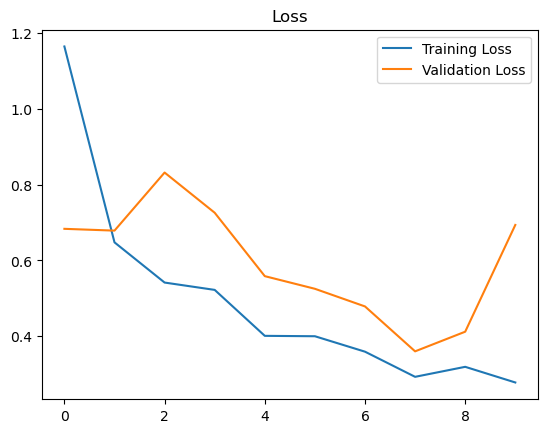

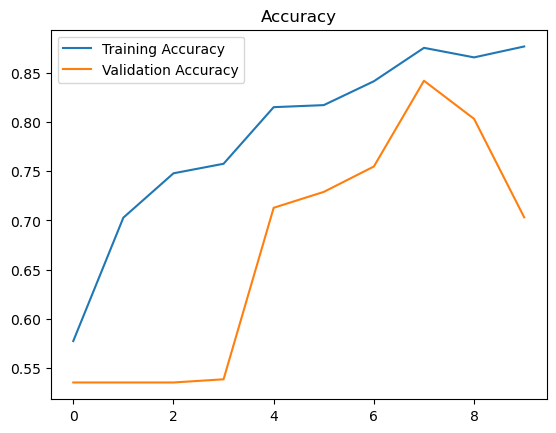

In [39]:
plot_metrics(history) 

# Results

In [41]:
best_model = load_model(filepath='models/best_cnn_model08-0.84.keras')

In [42]:
best_model.metrics_names

['loss', 'compile_metrics']

In [43]:
loss, acc = best_model.evaluate(x=X_test, y=y_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 271ms/step - accuracy: 0.8485 - loss: 0.3441


In [44]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {acc}")

Test Loss = 0.3330816328525543
Test Accuracy = 0.8580645322799683


### F1 score for the best model on the testing data:

In [45]:
y_test_prob = best_model.predict(X_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 257ms/step


In [41]:
f1score = compute_f1_score(y_test, y_test_prob)
print(f"F1 score: {f1score}")

F1 score: 0.8881578947368421


In [42]:
y_val_prob = best_model.predict(X_val)

10/10 [==============================] - 2s 235ms/step


In [43]:
f1score_val = compute_f1_score(y_val, y_val_prob)
print(f"F1 score: {f1score_val}")

F1 score: 0.8846153846153847


### Results Interpretation

In [44]:
def data_percentage(y):
    
    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive
    
    pos_prec = (n_positive* 100.0)/ m
    neg_prec = (n_negative* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {n_positive}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {n_negative}") 


In [45]:
data_percentage(y)

Number of examples: 2064
Percentage of positive examples: 52.51937984496124%, number of pos examples: 1084
Percentage of negative examples: 47.48062015503876%, number of neg examples: 980


In [46]:
print("Training Data:")
data_percentage(y_train)
print("Validation Data:")
data_percentage(y_val)
print("Testing Data:")
data_percentage(y_test)

Training Data:
Number of examples: 1444
Percentage of positive examples: 53.11634349030471%, number of pos examples: 767
Percentage of negative examples: 46.88365650969529%, number of neg examples: 677
Validation Data:
Number of examples: 310
Percentage of positive examples: 51.61290322580645%, number of pos examples: 160
Percentage of negative examples: 48.38709677419355%, number of neg examples: 150
Testing Data:
Number of examples: 310
Percentage of positive examples: 50.645161290322584%, number of pos examples: 157
Percentage of negative examples: 49.354838709677416%, number of neg examples: 153


# Conclusion:

#### Now, the model detects brain tumor with:<br>
**88.7%** accuracy on the **test set**.<br>
**0.88** f1 score on the **test set**.<br>
These resutls are very good considering that the data is balanced.

**Performance Table:**

| <!-- -->  | Validation set | Test set |
| --------- | -------------- | -------- |
| Accuracy  | 91%            | 89%      |
| F1 score  | 0.91           | 0.88     |